РЕГРЕССИЯ ДЛЯ log_IC50

Загрузка библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

sns.set_style("whitegrid")

Загрузка датасета

In [2]:
print("Загрузка обработанного датафрейма")
processed_excel_file = 'processed_compounds_data.xlsx'
df = pd.read_excel(processed_excel_file)

Загрузка обработанного датафрейма


In [3]:
print("Определение признаков и целевых переменных для каждой задачи")
feature_columns = [
    col for col in df.columns
    if col not in ['IC50, mM', 'CC50, mM', 'SI', 'log_IC50', 'log_CC50', 'log_SI']
    and df[col].dtype in ['float64', 'int64']
]

if not feature_columns:
    print("Ошибка: Не удалось найти числовые признаки для моделирования. Проверьте ваш DataFrame.")
    exit()

print(f"Общее количество доступных признаков-дескрипторов: {len(feature_columns)}")
# print("Примеры признаков:", feature_columns[:5]) # Для проверки

Определение признаков и целевых переменных для каждой задачи
Общее количество доступных признаков-дескрипторов: 163


Функция для оценки модели и вывода результатов

In [4]:
#  Функция для оценки модели и вывода результатов
def evaluate_model(model, X_test, y_test, target_name, model_name):
    """Оценивает модель и выводит метрики, а также график прогнозов."""
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Результаты для {model_name} (Прогнозирование {target_name})")
    print(f"Среднеквадратичная ошибка (MSE): {mse:.4f}")
    print(f"Корень из среднеквадратичной ошибки (RMSE): {rmse:.4f}")
    print(f"Средняя абсолютная ошибка (MAE): {mae:.4f}")
    print(f"Коэффициент детерминации (R^2): {r2:.4f}")

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.title(f'Прогнозы {model_name} vs Фактические значения ({target_name})')
    plt.xlabel(f'Фактические значения {target_name}')
    plt.ylabel(f'Прогнозируемые значения {target_name}')
    plt.grid(True)
    plt.show()

    return {'model_name': model_name, 'target': target_name, 'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2}

In [5]:
results_summary = [] # Для сбора результатов всех моделей

In [6]:
# Создаем набор признаков, исключая CC50, SI и их логарифмированные версии
X_ic50_features = [col for col in feature_columns if 'CC50' not in col and 'SI' not in col]
y_ic50 = df['log_IC50']
X_ic50 = df[X_ic50_features]

# Разделение на обучающую и тестовую выборки
X_train_ic50, X_test_ic50, y_train_ic50, y_test_ic50 = train_test_split(X_ic50, y_ic50, test_size=0.2, random_state=42)

# Масштабирование признаков
scaler_ic50 = StandardScaler()
X_train_ic50_scaled = scaler_ic50.fit_transform(X_train_ic50)
X_test_ic50_scaled = scaler_ic50.transform(X_test_ic50)

Обучение Linear Regression для log_IC50
Результаты для Linear Regression (Прогнозирование log_IC50)
Среднеквадратичная ошибка (MSE): 0.7880
Корень из среднеквадратичной ошибки (RMSE): 0.8877
Средняя абсолютная ошибка (MAE): 0.6731
Коэффициент детерминации (R^2): 0.2091


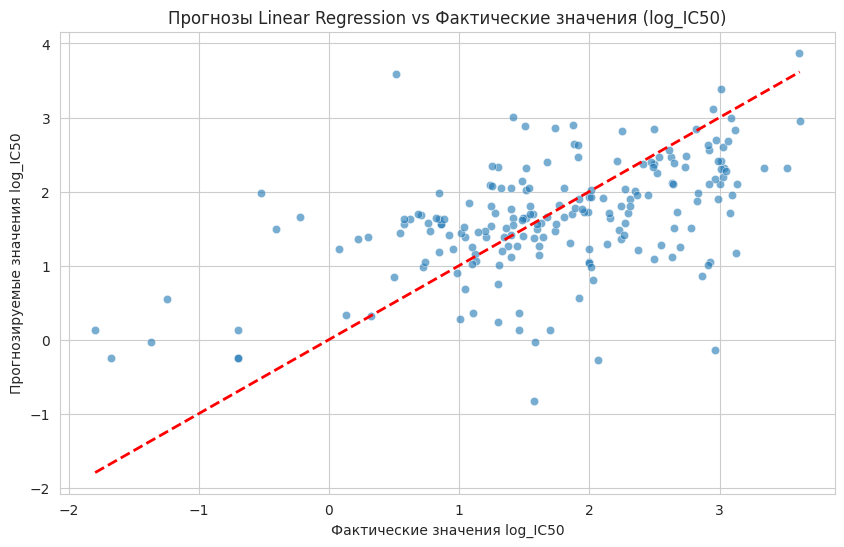

In [7]:
# 1. Линейная регрессия
print("Обучение Linear Regression для log_IC50")
lr_ic50 = LinearRegression()
lr_ic50.fit(X_train_ic50_scaled, y_train_ic50)
results_summary.append(evaluate_model(lr_ic50, X_test_ic50_scaled, y_test_ic50, 'log_IC50', 'Linear Regression'))

Настройка гиперпараметров для Random Forest Regressor (log_IC50)...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Лучшие гиперпараметры для Random Forest (log_IC50): {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 300}
Результаты для Random Forest (Прогнозирование log_IC50)
Среднеквадратичная ошибка (MSE): 0.4883
Корень из среднеквадратичной ошибки (RMSE): 0.6988
Средняя абсолютная ошибка (MAE): 0.5443
Коэффициент детерминации (R^2): 0.5098


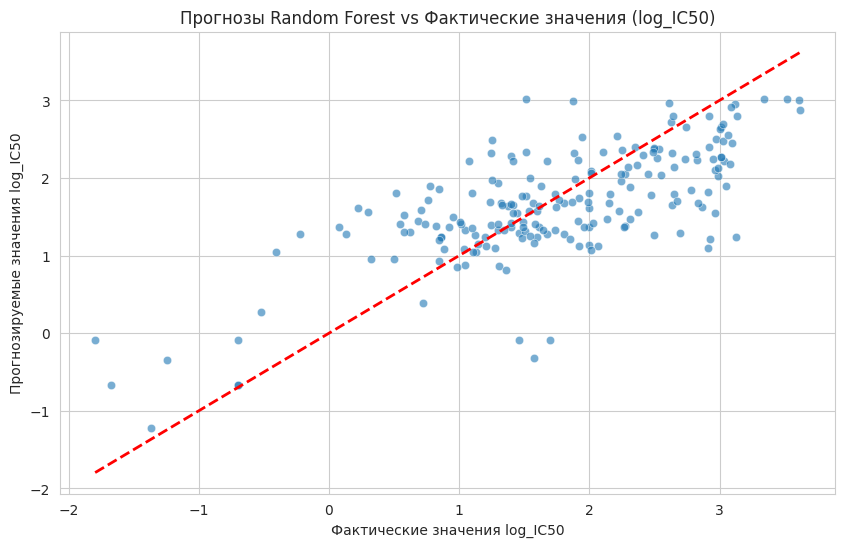

In [8]:
# 2. Random Forest Regressor
print("Настройка гиперпараметров для Random Forest Regressor (log_IC50)...")
param_grid_rf = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, None],
        'min_samples_leaf': [1, 2, 4]}
grid_search_rf_ic50 = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search_rf_ic50.fit(X_train_ic50, y_train_ic50) # RF не требует масштабирования
best_rf_ic50 = grid_search_rf_ic50.best_estimator_
print(f"Лучшие гиперпараметры для Random Forest (log_IC50): {grid_search_rf_ic50.best_params_}")
results_summary.append(evaluate_model(best_rf_ic50, X_test_ic50, y_test_ic50, 'log_IC50', 'Random Forest'))

Настройка гиперпараметров для Gradient Boosting Regressor (log_IC50)
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Лучшие гиперпараметры для Gradient Boosting (log_IC50): {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Результаты для Gradient Boosting (Прогнозирование log_IC50)
Среднеквадратичная ошибка (MSE): 0.5033
Корень из среднеквадратичной ошибки (RMSE): 0.7094
Средняя абсолютная ошибка (MAE): 0.5578
Коэффициент детерминации (R^2): 0.4949


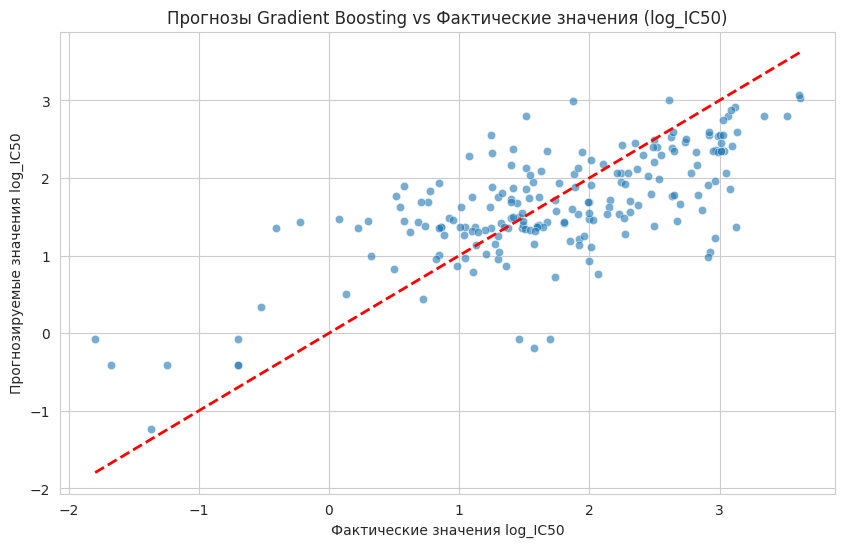

In [9]:
# 3. Gradient Boosting Regressor
print("Настройка гиперпараметров для Gradient Boosting Regressor (log_IC50)")
param_grid_gb = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]}
grid_search_gb_ic50 = GridSearchCV(GradientBoostingRegressor(random_state=42), param_grid_gb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search_gb_ic50.fit(X_train_ic50, y_train_ic50) # GB не требует масштабирования
best_gb_ic50 = grid_search_gb_ic50.best_estimator_
print(f"Лучшие гиперпараметры для Gradient Boosting (log_IC50): {grid_search_gb_ic50.best_params_}")
results_summary.append(evaluate_model(best_gb_ic50, X_test_ic50, y_test_ic50, 'log_IC50', 'Gradient Boosting'))

Настройка гиперпараметров для XGBoost Regressor (log_IC50)...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Лучшие гиперпараметры для XGBoost (log_IC50): {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Результаты для XGBoost (Прогнозирование log_IC50)
Среднеквадратичная ошибка (MSE): 0.5161
Корень из среднеквадратичной ошибки (RMSE): 0.7184
Средняя абсолютная ошибка (MAE): 0.5568
Коэффициент детерминации (R^2): 0.4820


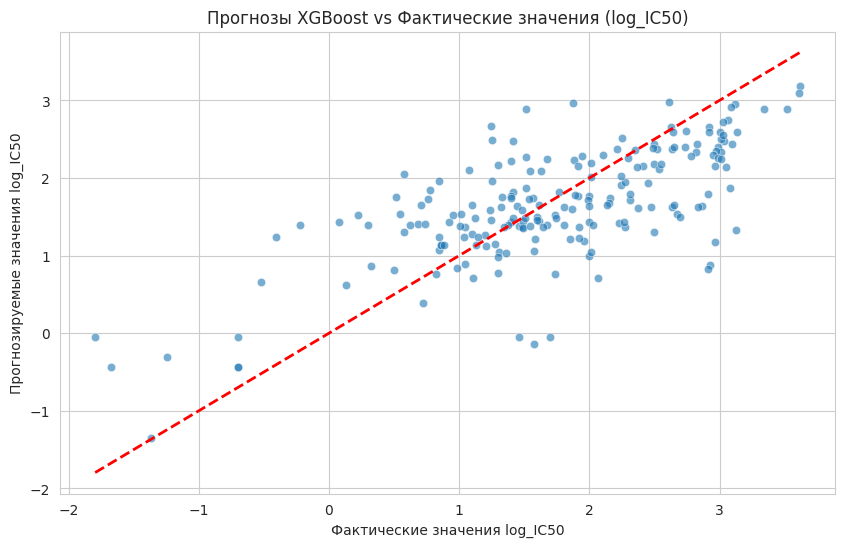

In [10]:
# 4. XGBoost Regressor
print("Настройка гиперпараметров для XGBoost Regressor (log_IC50)...")
param_grid_xgb = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]}
grid_search_xgb_ic50 = GridSearchCV(xgb.XGBRegressor(objective='reg:squarederror', random_state=42), param_grid_xgb, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search_xgb_ic50.fit(X_train_ic50, y_train_ic50) # XGBoost не требует масштабирования
best_xgb_ic50 = grid_search_xgb_ic50.best_estimator_
print(f"Лучшие гиперпараметры для XGBoost (log_IC50): {grid_search_xgb_ic50.best_params_}")
results_summary.append(evaluate_model(best_xgb_ic50, X_test_ic50, y_test_ic50, 'log_IC50', 'XGBoost'))

In [12]:
# таблица результатов
print("Таблица результатов моделей для log_IC50")
results_df = pd.DataFrame(results_summary)
print(results_df.sort_values(by=['target', 'R2'], ascending=[True, False]))

Таблица результатов моделей для log_IC50
          model_name    target       MSE      RMSE       MAE        R2
1      Random Forest  log_IC50  0.488339  0.698812  0.544276  0.509827
2  Gradient Boosting  log_IC50  0.503255  0.709405  0.557829  0.494854
3            XGBoost  log_IC50  0.516111  0.718409  0.556773  0.481951
0  Linear Regression  log_IC50  0.787951  0.887666  0.673129  0.209089


Вывод:

Наилучший результат по метрике R² показала модель Random Forest, что подтверждает её эффективность при работе с большим количеством признаков, имеющих нелинейные зависимости. Линейная регрессия значительно уступила остальным моделям, что свидетельствует о сложности зависимости между признаками и целевой переменной.